In [1]:
import sys
sys.path.append("../src")

In [2]:
import os
import itertools
from typing import List, Tuple

import cv2
import pyvips
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

from utils import *

In [3]:
data_dir = os.path.join("..", "data", "images")
image_names = os.listdir(data_dir)

print("num images:", len(image_names))

num images: 127


In [4]:
image_paths = [os.path.join(data_dir, i) for i in image_names]

images = [pyvips.Image.new_from_file(f, access="sequential") for f in image_paths]

In [5]:
# image = images[0]
image = images[image_names.index("10565.ome.tif")]

image = image.numpy()

height, width = image.shape[:2]

/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_3055/610090031.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


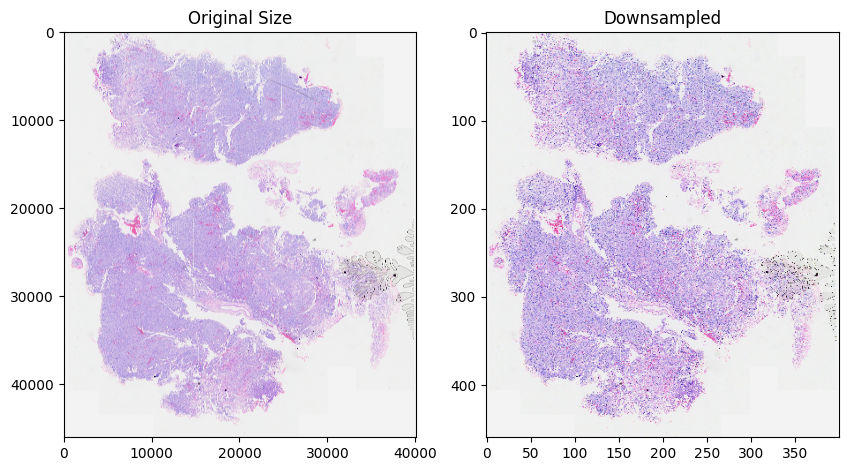

In [6]:
scaling_factor = 100
downsampled = downsample(image, scaling_factor)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(image)
axes[0].set_title("Original Size")

axes[1].imshow(downsampled)
axes[1].set_title("Downsampled")

fig.show()

In [7]:
def get_valid_contours(contours: List[np.ndarray]) -> List[np.ndarray]:
    valid_contours = []

    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        if w > 30 and h > 30:
            valid_contours.append(contour)

    return valid_contours

def get_contours(
    image: np.ndarray,
    threshold: int = 230,
    kernel_size: Tuple[int] = (5, 5)
    ) -> List[np.ndarray]:

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    binary = cv2.GaussianBlur(binary, kernel_size, 0)

    kernel = np.ones(kernel_size, np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    binary = cv2.erode(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = get_valid_contours(contours)

    return contours, binary

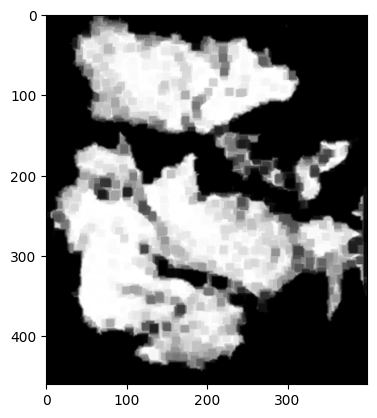

In [8]:
contours, binary = get_contours(downsampled)

plt.imshow(binary, cmap="gray")
plt.show()

In [9]:
len(contours)

1

In [10]:
upscaled_contours = [c * scaling_factor for c in contours]
contour_image = image.copy()
contour_image = cv2.drawContours(contour_image, upscaled_contours, -1, (0, 255, 0), 200)

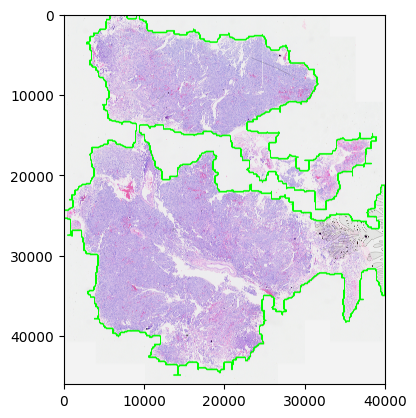

In [11]:
plt.imshow(contour_image)
plt.show()

In [12]:
contour_mask = np.zeros_like(image, dtype=np.float32)

contour_mask.shape

(46012, 40061, 3)

In [13]:
contour_mask = cv2.drawContours(contour_mask, upscaled_contours, -1, (1, 1, 1), cv2.FILLED)

plt.imshow(contour_mask)

plt.show()

In [ ]:
def get_coordinates(
    contours: List[Tuple[int, int, int, int]]
    ) -> List[Tuple[int]]:
    
    coordinates = [{"coordinates": cv2.boundingRect(c), "contours": c} for c in contours]

    return coordinates

In [ ]:
def squeeze_coordinates(
    coordinates: List[Tuple[int]],
    spacing: int = 10
    ) -> List[Tuple[int]]:

    squeezed_coordinates = []
    sorted_coordinates = sorted(coordinates, key=lambda x: (x["coordinates"][1], x["coordinates"][0]))
    max_width = max(sorted_coordinates, key=lambda x: x["coordinates"][2])
    max_width = max_width["coordinates"][2]
    max_width = max_width if max_width > 10_000 else 10_000

    pointer_x, pointer_y = 0, 0

    for c in sorted_coordinates:
        c = c["coordinates"]
        tissue_width, tissue_height = c[2], c[3]

        if (pointer_x + tissue_width) > max_width:
            pointer_y += (max(squeezed_coordinates, key=lambda x: (x[1], x[3]))[3] + spacing)
            pointer_x = 0
        
        squeezed_coordinates.append((pointer_x, pointer_y, tissue_width, tissue_height))
        pointer_x += squeezed_coordinates[-1][2] + spacing

    coordinate_dict = {
        "sorted_coordinates": sorted_coordinates,
        "squeezed_coordinates": squeezed_coordinates
    }

    return coordinate_dict

In [ ]:
def organize_tissues(
    image: np.ndarray,
    spacing: int,
    coordinate_dict: List[Dict[str, Union[np.ndarray, List[int]]]]
    ) -> np.ndarray:

    """
    This script processes the whole slide image along with the tissue contours,
    removing whitespace between tissues to preserve the essential information within the image.
    """

    sorted_coordinates = coordinate_dict["sorted_coordinates"]
    squeezed_coordinates = coordinate_dict["squeezed_coordinates"]

    max_width = max(sorted_coordinates, key=lambda x: x["coordinates"][2])
    max_width = max_width["coordinates"][2]
    max_width = max_width if max_width > 10_000 else 10_000

    rows_height = [max(group, key=lambda x: x[3])[3] + spacing for _, group in itertools.groupby(squeezed_coordinates, key=lambda x: x[1])]
    max_height = sum(rows_height)

    processed_image = np.ones((max_height, max_width, 3), dtype=np.uint8) * 255

    for sorted, squeezed in zip(sorted_coordinates, squeezed_coordinates):
        coordinates = sorted["coordinates"]
        contours = [sorted["contours"]]

        contour_mask = np.zeros_like(image, dtype=np.float32)
        contour_mask = cv2.drawContours(contour_mask, contours, -1, (1, 1, 1), cv2.FILLED)

        snapshot = image.copy() * contour_mask
        
        x0, y0, w0, h0 = coordinates
        x1, y1, w1, h1 = squeezed

        detected_tissue = snapshot[y0:y0+h0, x0:x0+w0]
        processed_image[y1:y1+h1, x1:x1+w1] = detected_tissue
    
    return processed_image

In [ ]:
coordinates = get_coordinates(upscaled_contours)

coordinate_dict = squeeze_coordinates(coordinates)

In [ ]:
[c["coordinates"] for c in coordinate_dict["sorted_coordinates"]]

[(2600, 0, 36501, 24501), (200, 14200, 39601, 30601)]

In [ ]:
# for a given y0, get  y1, then determine every point that lies below y1

In [ ]:
coordinate_dict["squeezed_coordinates"]

[(0, 0, 36501, 24501), (0, 24511, 39601, 30601)]

: 

In [21]:
processed_image = organize_tissues(image, 10, coordinate_dict)

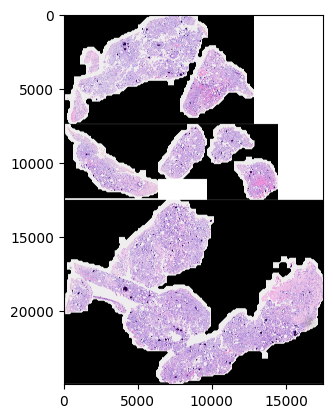

In [ ]:
plt.imshow(processed_image)
plt.show()

In [ ]:
image.shape

(23663, 21566, 3)

In [ ]:
processed_image.shape

(24933, 17501, 3)

In [ ]:
test_image = image.copy()
for c in coordinate_dict["sorted_coordinates"]:
    x, y, w, h = c["coordinates"]
    test_image = cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 200)

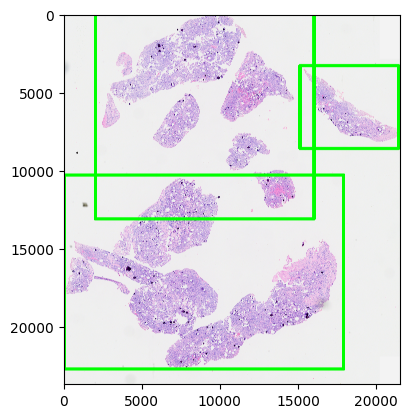

In [ ]:
plt.imshow(test_image)
plt.show()